# Flea beatle measurements


- `tars1`, width of the first joint of the first tarsus in microns (the sum of measurements for both tarsi)
- `tars2`, the same for the second joint
- `head`, the maximal width of the head between the external edges of the eyes in 0.01 mm
- `ade1`, the maximal width of the aedeagus in the fore-part in microns
- `ade2`, the front angle of the aedeagus ( 1 unit = 7.5 degrees)
- `ade3`, the aedeagus width from the side in microns
- `species`, which species is being examined - concinna, heptapotamica, heikertingeri

In [34]:
using Clustering
using Plots
using Random
using RCall
using Statistics

Julia equivalent of the `scale` R function

In [35]:
function scale!(x)

    for col in eachcol(x)
        μ, σ = mean(col), std(col)
        col .-= μ
        col ./= σ
    end

end

scale! (generic function with 1 method)

In [36]:
function plot_pointset(points, color)

    p = plot(; framestyle = :grid, aspect_ratio = true)

    for (i,c) in enumerate(unique(color))

        which = color .== c
        scatter!(
            p,
            points[which, 1],
            points[which, 2],
            color = i,
            markersize = 5,
            label = "$i",
        )

    end

    return p

end


plot_pointset (generic function with 1 method)

In [37]:
dataset = rcopy(R"tourr::flea")

Row,tars1,tars2,head,aede1,aede2,aede3,species
,Int64,Int64,Int64,Int64,Int64,Int64,Cat…
1,191,131,53,150,15,104,Concinna
2,185,134,50,147,13,105,Concinna
3,200,137,52,144,14,102,Concinna
4,173,127,50,144,16,97,Concinna
5,171,118,49,153,13,106,Concinna
6,160,118,47,140,15,99,Concinna
7,188,134,54,151,14,98,Concinna
8,186,129,51,143,14,110,Concinna
9,174,131,52,144,14,116,Concinna


In [38]:
points = Matrix(Float64.(dataset[:, 1:6]))
scale!(points)
labels = collect(enumerate(unique(dataset[:, 7])))

3-element Vector{Tuple{Int64, String}}:
 (1, "Concinna ")
 (2, "Heptapot. ")
 (3, "Heikert. ")

In [39]:
true_colors = zeros(Int, length(dataset[:, 7]))
for i in eachindex(true_colors, dataset[:, 7])
    for j in eachindex(labels)
        p = labels[j]
        if p[2] == dataset[i, 7]
            true_colors[i] = p[1]
        end
    end
end

## K-means 

[1] 0.8249883
NMI = 0.8249883014016557


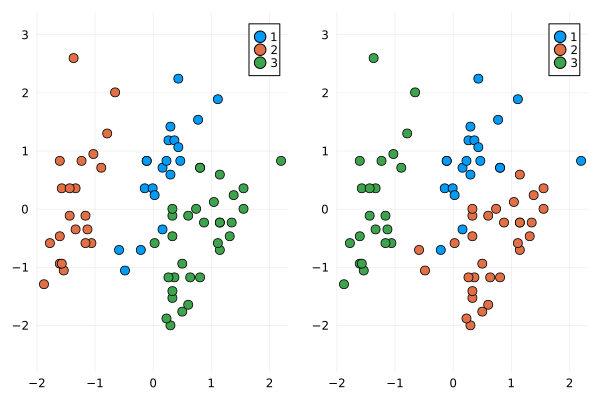

In [40]:
R"""
dataset = tourr::flea
true_color = c(rep(1,21),rep(2,22),rep(3,31))
P = scale(dataset[,1:6])
col_kmeans = kmeans(P,3)$cluster
print(aricode::NMI(col_kmeans,true_color))
"""
col_kmeans = @rget col_kmeans
println("NMI = $(mutualinfo(true_colors, col_kmeans))")
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, col_kmeans)
plot(p1, p2, layout = l, aspect_ratio = :equal)

## K-means from Clustering.jl

NMI = 0.8249883014016558


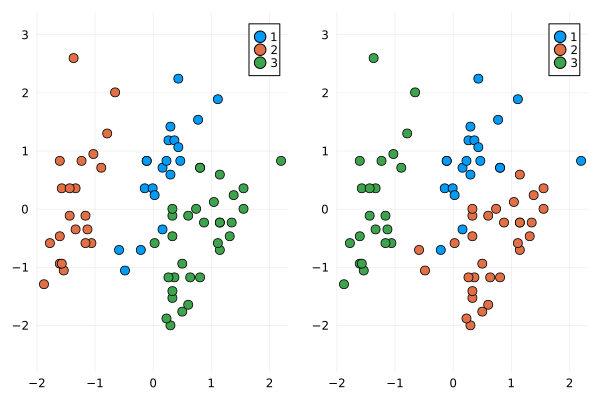

In [41]:
features = collect(points')
result = kmeans(features, 3)
println("NMI = $(mutualinfo(true_colors, result.assignments))")
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, result.assignments)
plot(p1, p2, layout = l, aspect_ratio = :equal)

## K-means from ClusterAnalysis.jl

NMI = 0.9156652902281732


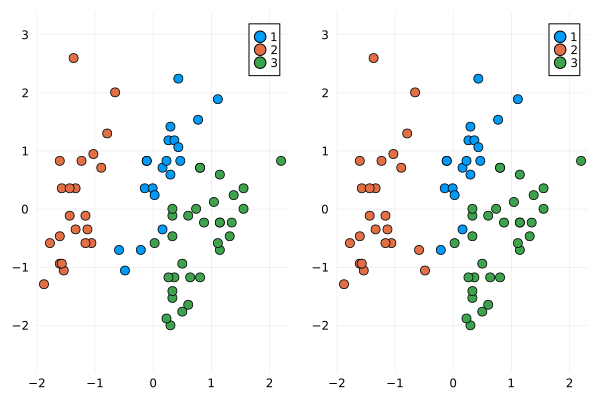

In [42]:
import ClusterAnalysis

flea = rcopy(R"tourr::flea")
df = flea[:, 1:end-1];  # dataset is stored in a DataFrame

# parameters of k-means
k, nstart, maxiter = 3, 10, 10;

model = ClusterAnalysis.kmeans(df, k, nstart = nstart, maxiter = maxiter)
println("NMI = $(mutualinfo(true_colors, model.cluster))")
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, model.cluster)
plot(p1, p2, layout = l, aspect_ratio = :equal)

## Robust trimmed clustering : tclust

NMI = 1.0


┌ Warning: RCall.jl: Warning in .tclust.warn(O, O$ret) :
│   The result is artificially constrained due to restr.fact = 10.
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


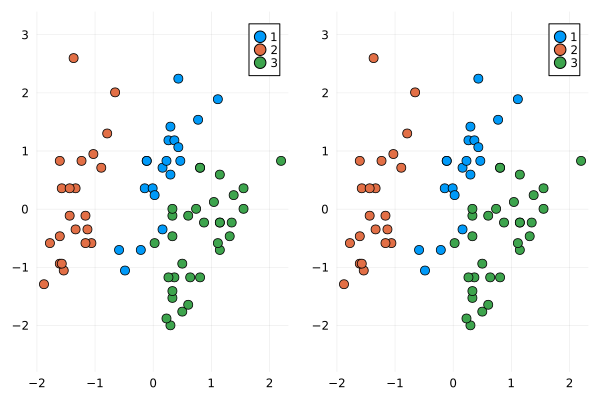

In [43]:
R"""
dataset = tourr::flea
P = scale(dataset[,1:6])
"""
tclust_color = Int.(rcopy(R"tclust::tclust(P,3,alpha = 0,restr.fact = 10)$cluster"))
println("NMI = $(mutualinfo(true_colors,tclust_color))")
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, tclust_color)
plot(p1, p2, layout = l, aspect_ratio = :equal)

## ToMaTo

Algorithm ToMATo from paper "Persistence-based clustering in Riemannian Manifolds"
Frederic Chazal, Steve Oudot, Primoz Skraba, Leonidas J. Guibas


NMI = 0.7462865445635402


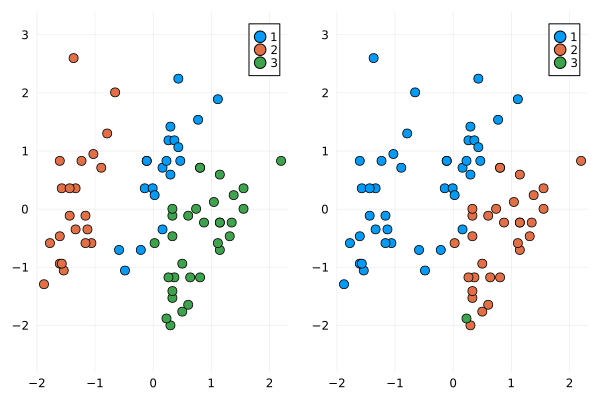

In [44]:
using GeometricClusterAnalysis


nb_clusters, k, c, radius, iter_max = 3, 10, 100, 1.9, 100
nsignal = size(points, 1)
col_tomato, _ = tomato_clustering(nb_clusters, points, k, c, nsignal, radius, iter_max, nstart)
println("NMI = $(mutualinfo(true_colors, col_tomato))")
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, col_tomato)
plot(p1, p2, layout = l)

In [45]:
R"""
source(here::here("R","plot_pointclouds_centers.R"))
source(here::here("R","DTM_filtration.R"))
source(here::here("R","functions_for_evaluating_methods.R"))

dataset = tourr::flea
P = dataset[,1:6]
true_color = c(rep(1,21),rep(2,22),rep(3,31))
P = scale(P)

source(here::here("R", "tomato.R"))
source(here::here("R", "hierarchical_clustering_complexes.R"))
print("tomato")
col_tomato = clustering_Tomato(3,P,10,100,nrow(P),1.9,100,10)$label
print(aricode::NMI(col_tomato,true_color))
"""


[1] "tomato"
[1] 0.6280869


RObject{RealSxp}
[1] 0.6280869


## DBSCAN

In [47]:
R"""
col_dbscan = dbscan::dbscan(P, 1.5,minPts = 10)$cluster
print(aricode::NMI(col_dbscan,true_color))
"""

[1] 0.6467992


RObject{RealSxp}
[1] 0.6467992


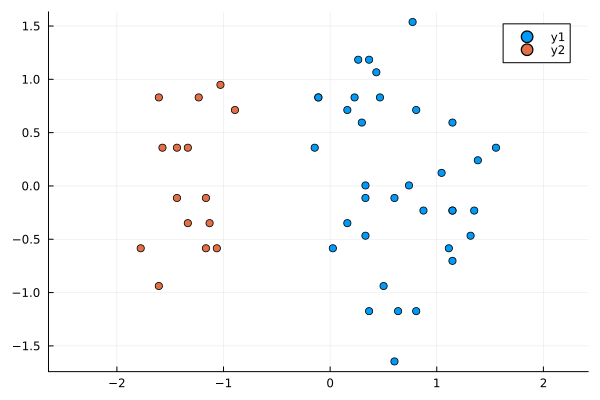

In [76]:
clusters = dbscan(x, 1.5, min_neighbors = 5, min_cluster_size = 10)
p = plot(aspect_ratio=true)
for cluster in clusters
    scatter!(p, x[1, cluster.core_indices], x[2, cluster.core_indices] )
end
p

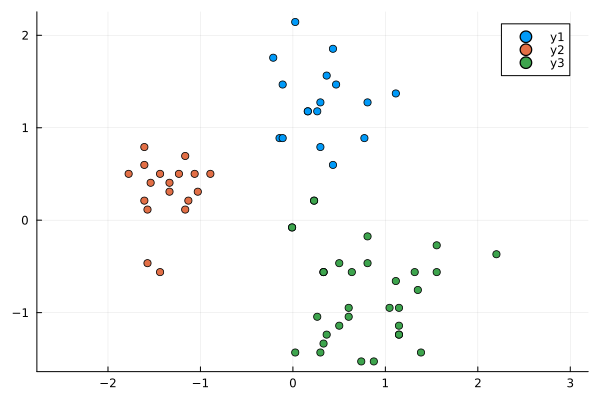

In [64]:
import ClusterAnalysis

m = ClusterAnalysis.dbscan(points, 1.5, 10)
p = plot(aspect_ratio = true)
for cluster in m.clusters
    scatter!(points[cluster,1], points[cluster, 4])
end
p

## k-PLM 

NMI = 1.0


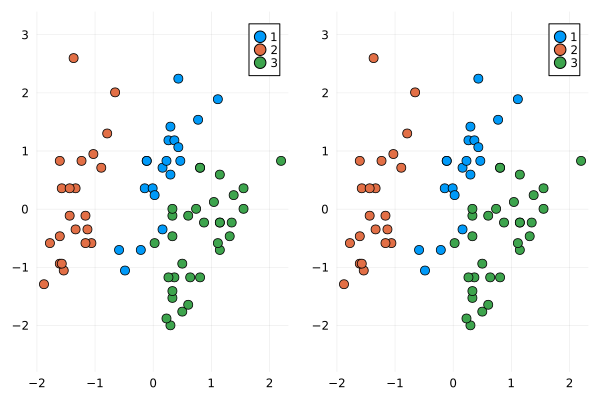

In [85]:
nb_clusters, k, c, iter_max, nstart = 3, 10, 50, 100, 10

function f_Σ!(Σ) end

rng = MersenneTwister(6625)

x = collect(transpose(points))

dist_func = kplm(rng, x, k, c, nsignal, iter_max, nstart, f_Σ!)

distance_matrix = build_distance_matrix(dist_func)

nb_means_removed = 0

threshold, infinity =
    compute_threshold_infinity(dist_func, distance_matrix, nb_means_removed, nb_clusters)
hc =
    hierarchical_clustering_lem(distance_matrix, infinity = infinity, threshold = threshold)
col_kplm = color_points_from_centers(x, k, nsignal, dist_func, hc)
println("NMI = $(mutualinfo(true_colors, col_kplm))")
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, col_kplm)
plot(p1, p2, layout = l)

In [86]:
R"""
f_Sigma <- function(Sigma){return(Sigma)}
col_PLM_nonhier = kplm(P,10,3,nrow(P),100,10,f_Sigma)$color
print(aricode::NMI(col_PLM_nonhier,true_color))
"""

[1] 0.3339049


RObject{RealSxp}
[1] 0.3339049


In [87]:
R"""
source(here::here("R", "kplm.R"))
source(here::here("R", "ellipsoids_intersection.R"))
col_PLM = clustering_PLM(3,P,10,50,nrow(P),100,10,nb_means_removed = 0)$label
print(aricode::NMI(col_PLM,true_color))
"""

[1] 1


RObject{RealSxp}
[1] 1


## Witnessed

In [82]:
R"""
source(here::here("R", "kpdtm.R"))
col_witnessed = clustering_witnessed(3,P,10,50,nrow(P),100,10)$label
print(aricode::NMI(col_witnessed,true_color))
"""

[1] 0.905818


RObject{RealSxp}
[1] 0.905818


NMI = 0.911166770886367


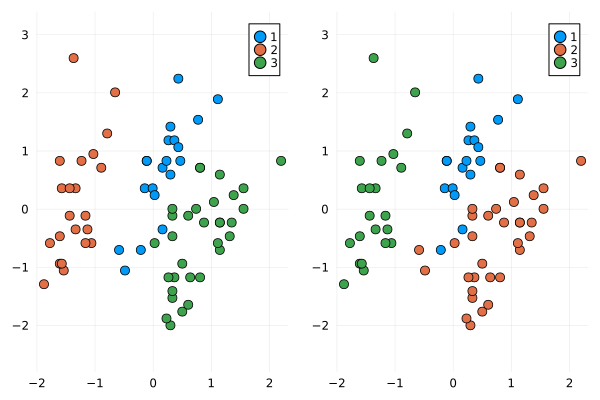

In [83]:
μ, ω, colors = k_witnessed_distance(x, k, c, nsignal)

distance_matrix = build_distance_matrix_power_function_buchet(sqrt.(ω), hcat(μ...))

hc1 = hierarchical_clustering_lem(distance_matrix, infinity = Inf, threshold = Inf)
bd = hc1.death .- hc1.birth
sort!(bd)
infinity = mean((bd[end-nb_clusters], bd[end-nb_clusters+1]))
hc2 = hierarchical_clustering_lem(distance_matrix, infinity = infinity, threshold = Inf)
witnessed_colors = return_color(colors, hc2.colors, hc2.startup_indices)
println("NMI = $(mutualinfo(true_colors, witnessed_colors))")

l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, witnessed_colors)
plot(p1, p2, layout = l)

## k-PDTM

NMI = 1.0


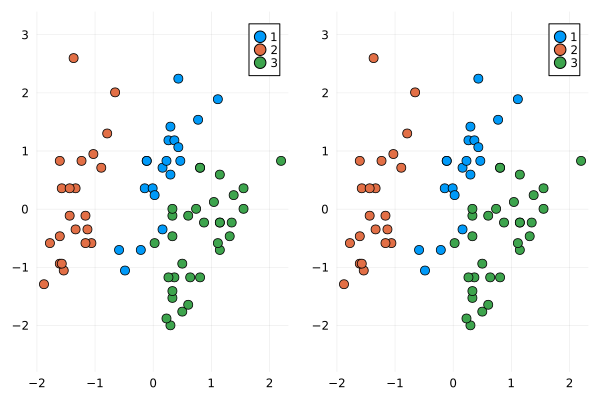

In [19]:
df_kpdtm = kpdtm(rng, x, k, c, nsignal, iter_max, nstart)
distance_matrix = build_distance_matrix(df_kpdtm)
hc1 = hierarchical_clustering_lem(distance_matrix, infinity = Inf, threshold = Inf)
bd = hc1.death .- hc1.birth
sort!(bd)
infinity = mean((bd[end-nb_clusters], bd[end-nb_clusters+1]))
hc2 = hierarchical_clustering_lem(distance_matrix, infinity = infinity, threshold = Inf)
kpdtm_colors = return_color(df_kpdtm.colors, hc2.colors, hc2.startup_indices)
println("NMI = $(mutualinfo(true_colors, kpdtm_colors))")

l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, kpdtm_colors)
plot(p1, p2, layout = l)

In [20]:
R"""
source(here::here("R","kpdtm.R"))
col_PDTM_nonhier = Trimmed_kPDTM(P,10,3,nrow(P),100,10)$color
print(aricode::NMI(col_PDTM_nonhier,true_color))
"""

[1] 0.8249883


RObject{RealSxp}
[1] 0.8249883


In [21]:
R"""
col_PDTM = clustering_PDTM(3,P,10,50,nrow(P),100,10)$label
print(aricode::NMI(col_PDTM,true_color))
"""

[1] 1


RObject{RealSxp}
[1] 1


## Power function Buchet et al.


NMI = 1.0


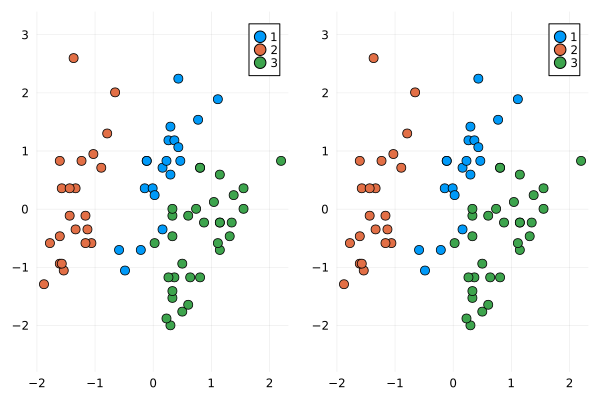

In [22]:
using GeometricClusterAnalysis

m0 = k / size(x, 2)
birth = sort(dtm(x, m0))
threshold = birth[nsignal]

distance_matrix = build_distance_matrix_power_function_buchet(birth, x)

buchet_colors, returned_colors, hc1 =
    power_function_buchet(x, m0; infinity = Inf, threshold = threshold)
sort_bd = sort(hc1.death .- hc1.birth)
infinity = mean((sort_bd[end-nb_clusters], sort_bd[end-nb_clusters+1]))
buchet_colors, returned_colors, hc2 =
    power_function_buchet(x, m0; infinity = infinity, threshold = threshold)
println("NMI = $(mutualinfo(true_colors, buchet_colors))")
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, buchet_colors)
plot(p1, p2, layout = l)

In [23]:
R"""
col_power = clustering_power_function(3,P,10,30,nrow(P),100,10)$label
print(aricode::NMI(col_power,true_color))
"""

[1] 1


RObject{RealSxp}
[1] 1


## DTM filtration


threshold = birth[nsignal] = 2.6665087936017264
NMI = 1.0


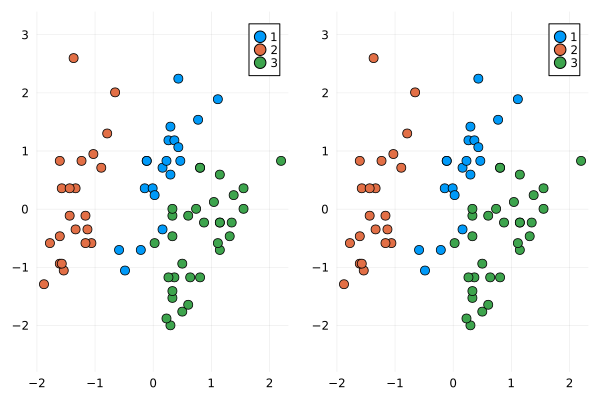

In [24]:
using GeometricClusterAnalysis

m0 = k / size(x, 2)
birth = sort(dtm(x, m0))
@show threshold = birth[nsignal]

distance_matrix = GeometricClusterAnalysis.distance_matrix_dtm_filtration(birth, x)

dtm_colors, returned_colors, hc1 =
    dtm_filtration(x, m0; infinity = Inf, threshold = threshold)
sort_bd = sort(hc1.death .- hc1.birth)
infinity = mean((sort_bd[end-nb_clusters], sort_bd[end-nb_clusters+1]))
dtm_colors, returned_colors, hc2 =
    dtm_filtration(x, m0; infinity = infinity, threshold = threshold)
println("NMI = $(mutualinfo(true_colors, dtm_colors))")
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, dtm_colors)
plot(p1, p2, layout = l)

In [25]:
R"""
col_DTM_filtration = clustering_DTM_filtration(3,P,10,30,nrow(P),100,10)$label
print(aricode::NMI(col_DTM_filtration,true_color))
"""

[1] 1


RObject{RealSxp}
[1] 1


## Spectral with `specc`

NMI = 1.0000000000000002


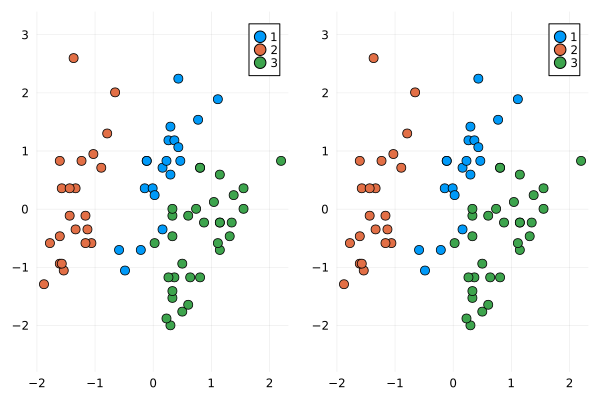

In [26]:
spectral_colors = rcopy(R"kernlab::specc(P, centers = 3)")
println("NMI = $(mutualinfo(true_colors, spectral_colors))")
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, spectral_colors)
plot(p1, p2, layout = l)

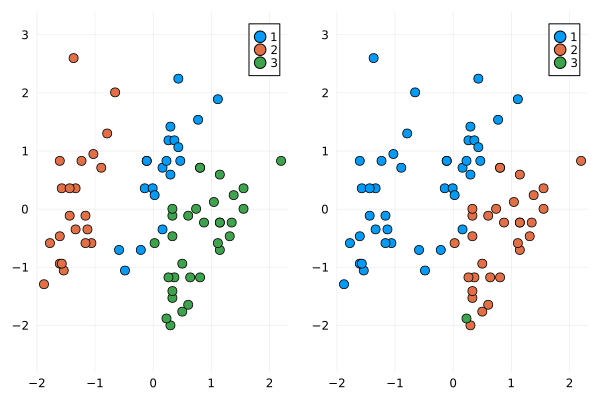

In [27]:
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, Int.(rcopy(R"col_tomato")))
plot(p1, p2, layout = l)

In [28]:
R"""
col_spectral = kernlab::specc(P, centers=3)
col_spectral2 = rep(0,nrow(P))
for(i in 1:nrow(P)){col_spectral2[i] = col_spectral[[i]]}
print(aricode::NMI(col_spectral2,true_color))
"""

[1] 1


RObject{RealSxp}
[1] 1


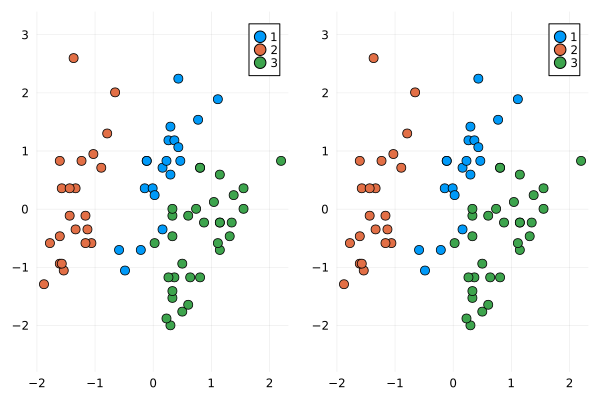

In [29]:
l = @layout [a b]
p1 = plot_pointset(points, true_colors)
p2 = plot_pointset(points, Int.(rcopy(R"col_PLM")))
plot(p1, p2, layout = l)